In [99]:
import pandas as pd
import numpy as np

## lab day 4, part 1

In part 1, following will be done:
- xy split
- train test split
- numerical categorical split
- encode, scale
- oversample the train data
- run classifier(s)<br>
<br>then display the prediction scores.<br>
In part 2, feature selection will be done before running the classifiers once again. The results will be compared

In [100]:
categorical = pd.read_csv("categorical.csv")
numerical = pd.read_csv("numerical.csv")
target = pd.read_csv("target.csv")

In [101]:
# checking nan
data = pd.concat([categorical, numerical, target], axis = 1)
data.isna().sum().sum()

2

In [102]:
# checking column where it has nan
na = pd.DataFrame(data.isna().sum(), columns = ["col"])
na = na[na.col != 0].index.values.tolist()
na

['FIRSTDATE_MM']

In [103]:
# checking rows in where it has nan in that specific column
data.FIRSTDATE_MM[data.FIRSTDATE_MM.isna() == True]

83217   NaN
93811   NaN
Name: FIRSTDATE_MM, dtype: float64

In [104]:
# drop rows
print(data.shape[0])
data = data.drop([83217,93811])
print(data.shape[0])

95412
95410


In [105]:
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
X = data.drop(columns = ["TARGET_B","TARGET_D"])
y = data[["TARGET_B","TARGET_D"]]
# d = data["TARGET_D"]
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=23)

In [106]:
def scale(train, test):
    scaler = MinMaxScaler().fit(train)
    train_scaled = scaler.transform(train)
    test_scaled = scaler.transform(test)
    cols = scaler.get_feature_names_out(input_features = train.columns)
    train_scaled = pd.DataFrame(train_scaled, columns = cols)
    test_scaled = pd.DataFrame(test_scaled, columns = cols)
    return train_scaled, test_scaled

In [107]:
def encode(train, test):
    encoder = OneHotEncoder().fit(train)
    train_encoded = encoder.transform(train).toarray()
    test_encoded = encoder.transform(test).toarray()
    train_encoded = pd.DataFrame(train_encoded)
    test_encoded = pd.DataFrame(test_encoded)
    return train_encoded, test_encoded


In [108]:
def num_cat_split(xtrain, xtest):
    num_train = xtrain.select_dtypes(np.number)
    num_test = xtest.select_dtypes(np.number)
    cat_train = xtrain.select_dtypes(object)
    cat_test = xtest.select_dtypes(object)
    return num_train, num_test, cat_train, cat_test

In [196]:
def processing(xtrain, xtest, to_scale, to_encode):
    num_train, num_test, cat_train, cat_test = num_cat_split(xtrain, xtest)
    if to_scale:
        train_scaled, test_scaled = scale(num_train, num_test)
    else:
        train_scaled = num_train
        test_scaled = num_test
    if to_encode:
        train_encoded, test_encoded = encode(cat_train, cat_test)
    else:
        train_encoded = cat_train
        test_encoded = cat_test
    train_scaled = train_scaled.reset_index(drop = True)
    train_encoded = train_encoded.reset_index(drop = True)
    test_scaled = test_scaled.reset_index(drop = True)
    test_encoded = test_encoded.reset_index(drop = True)
    xtrain = pd.concat([train_scaled, train_encoded], axis = 1)
    xtest = pd.concat([test_scaled, test_encoded], axis = 1)
    return xtrain, xtest

In [110]:
def combine_xy(xtrain, ytrain):
    xtrain = xtrain.reset_index(drop = True)
    ytrain = ytrain.reset_index(drop = True)
    train = pd.concat([xtrain, ytrain], axis = 1)
    return train

after train test split, run this function to:
- split numerical categorical for train and test
- minmax scaler for numerical train and numerical test. create dataframes
- onehot encoder for categorical train and categorical test. create dataframes
- pd concat numerical + categorical train, numerical + categorical test
- return X_train_processed and X_test_processed

In [111]:
to_scale = True
to_encode = True
X_train, X_test = processing(X_train, X_test, to_scale, to_encode)

In [112]:
from sklearn.utils import resample
train = combine_xy(X_train, y_train)
train.isna().sum().sum()

0

In [113]:
train_1 = train[train.TARGET_B == 1]
train_0 = train[train.TARGET_B == 0]
train_1_over = resample(train_1, replace = True, n_samples = len(train_0), random_state = 33)
train_over = pd.concat([train_1_over, train_0], axis = 0)
x_train_over = train_over.drop(columns = "TARGET_B").copy()
y_train_over = train_over[["TARGET_B"]].copy()
to_drop = ["index", "level_0", "TARGET_D"]
for i in to_drop:
    try:
        x_train_over = x_train_over.drop(columns = i)
    except:
        pass

In [118]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [202]:
def run_pipeline_clf(x_train_over, X_train, X_test, y_train_over, y_test):
    dt_clf = DecisionTreeClassifier()
    logr = LogisticRegression(max_iter = 500)
    kn_clf = KNeighborsClassifier()
    rf_clf = RandomForestClassifier(max_depth=5, min_samples_split=10, min_samples_leaf =30, max_samples=0.7, random_state = 42)
    model_pipeline = [dt_clf, logr, kn_clf, rf_clf]
    model_name = ["decision_tree_clf","logistic_regr","k_neighbors_clf","random_forest_clf"]
    scores = {}
    preds_train = {}
    preds_test = {}
    confusion = {}
    for i,j in zip(model_pipeline, model_name):
        mean_score = np.mean(cross_val_score(i, x_train_over, y_train_over, cv = 5))
        scores[j] = mean_score
        i.fit(x_train_over, y_train_over)
        pred_train = i.predict(X_train)
        preds_train[j] = pred_train
        pred_test = i.predict(X_test)
        preds_test[j] = pred_test
        confusion[j] = confusion_matrix(y_test,pred_test)
    return scores, preds_train, preds_test, confusion

In [ ]:
# so basically it's training using oversampled data, to make prediction both for
# train and test part. because we want to predict the TARGET_B for all person.
# we will get 1/0 for all rows. this prediction result will then be concatenated
# to the full dataframe.
# full dataframe consists of:
# X_train, y_train, target_D (train part), pred_train,
# X_test, y_test, target_D (test part), pred_test, altogether

### getting results

In [124]:
scores, preds_train, preds_test, confusion = run_pipeline_clf(x_train_over, X_train, X_test, y_train_over, y_test[["TARGET_B"]])

d:\Python 3.10\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Python 3.10\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

In [125]:
scores

{'decision_tree_clf': 0.9673288739767333,
 'logistic_regr': 0.6031629319929785,
 'k_neighbors_clf': 0.9141563219132494,
 'random_forest_clf': 0.6183905955233309}

In [126]:
preds_train

{'decision_tree_clf': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'logistic_regr': array([0, 0, 1, ..., 0, 0, 1], dtype=int64),
 'k_neighbors_clf': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'random_forest_clf': array([0, 0, 0, ..., 0, 0, 1], dtype=int64)}

In [127]:
preds_test

{'decision_tree_clf': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'logistic_regr': array([0, 0, 0, ..., 0, 1, 0], dtype=int64),
 'k_neighbors_clf': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'random_forest_clf': array([1, 0, 0, ..., 0, 1, 0], dtype=int64)}

In [128]:
confusion

{'decision_tree_clf': array([[17110,  1023],
        [  883,    66]], dtype=int64),
 'logistic_regr': array([[11276,  6857],
        [  424,   525]], dtype=int64),
 'k_neighbors_clf': array([[15642,  2491],
        [  801,   148]], dtype=int64),
 'random_forest_clf': array([[11338,  6795],
        [  437,   512]], dtype=int64)}

## lab day 4, part 2

In [ ]:
# I take original X_train, X_test here to do feature selection.
# then I only use a few columns from them, and use the same columns from x_train_over 
# to make a new prdiction. this time with only selected features.

In [132]:
X_train, X_test = scale(X_train, X_test)

In [136]:
X_train.dtypes

CLUSTER      float64
DATASRCE     float64
DOMAIN_B     float64
ODATEW_YR    float64
ODATEW_MM    float64
              ...   
26           float64
27           float64
28           float64
29           float64
30           float64
Length: 361, dtype: object

In [138]:
num_scaler = MinMaxScaler().fit(numerical)
num_scaled = num_scaler.transform(numerical)
cols = num_scaler.get_feature_names_out(input_features = numerical.columns)
num_scaled = pd.DataFrame(num_scaled, columns = cols)

In [139]:
from sklearn.feature_selection import RFE
from sklearn import linear_model


x = num_scaled
y = target["TARGET_B"]
lm = linear_model.LinearRegression()
rfe = RFE(lm, n_features_to_select=30, verbose=False)
rfe.fit(x, y)

ranking = pd.DataFrame(data = rfe.ranking_, columns=['rank'])
ranking['column'] = pd.DataFrame(num_scaled).columns
cols_to_drop = ranking.column[ranking['rank']!=1].tolist()
len(cols_to_drop)

285

In [140]:
num_selected = num_scaled.drop(columns = cols_to_drop)
corr = pd.concat([num_selected, target.TARGET_B], axis = 1).corr()
# take out the columns with negative collinearity with target B
negative_corr = corr.TARGET_B[corr.TARGET_B < 0].index.values.tolist()
# take out the columns with awfully high collinearity with target B
high_corr = corr.TARGET_B[corr.TARGET_B > .9].index.values.tolist()
to_drop = negative_corr + high_corr
print(len(num_selected.columns))
for i in to_drop:
    try:
        num_selected = num_selected.drop(columns = i)
    except:
        pass
corr = pd.concat([num_selected, target.TARGET_B], axis = 1).corr()
print(len(num_selected.columns))

30
9


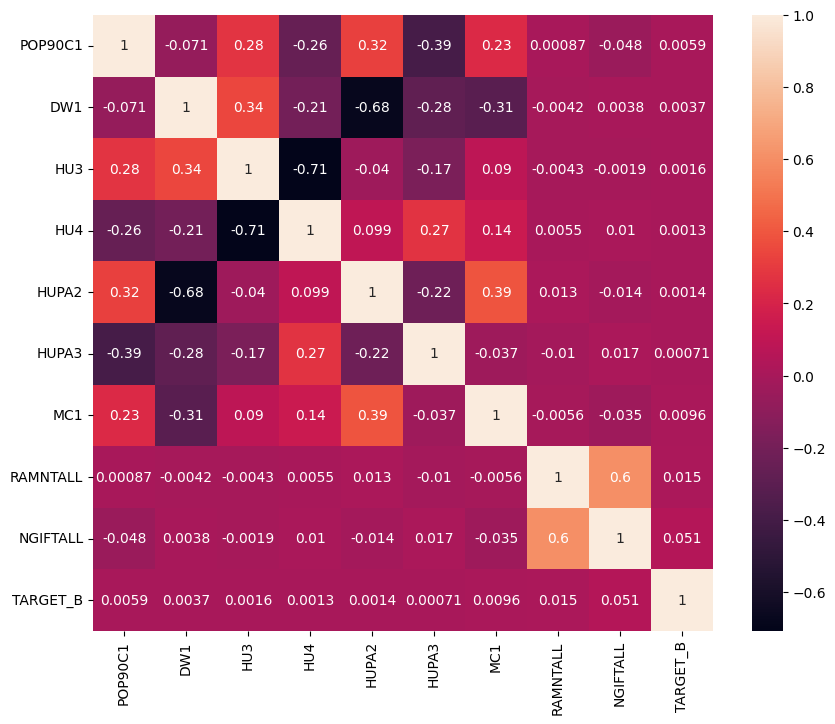

In [141]:
# bruh it's deleting soooo many columns. not my fault, I started with 30 columns,
# which I think is already plenty. not that I have any problem with that.
# less columns, better looking heatmap, right? lets see
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(corr, annot=True)
plt.show()

In [ ]:
# gorgeous.

In [142]:
# remove these columns from X_train, X_test, and x_train_over
to_drop = to_drop + cols_to_drop
for i in to_drop:
    try:
        X_train = X_train.drop(columns = i)
    except:
        pass
    try:
        X_test = X_test.drop(columns = i)
    except:
        pass
    try:
        x_train_over = x_train_over.drop(columns = i)
    except:
        pass

In [144]:
print(len(x_train_over.columns), len(X_train.columns), len(X_test.columns))

55 55 55


In [ ]:
# ready to rock.

### getting results (2)
sorry this is starting to look uglier and uglier

In [145]:
scores2, preds_train2, preds_test2, confusion2 = run_pipeline_clf(x_train_over, X_train, X_test, y_train_over, y_test[["TARGET_B"]])

In [146]:
scores2

{'decision_tree_clf': 0.966127775230477,
 'logistic_regr': 0.5814535259083782,
 'k_neighbors_clf': 0.9137214542720038,
 'random_forest_clf': 0.5959011583326327}

In [147]:
preds_train2

{'decision_tree_clf': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'logistic_regr': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'k_neighbors_clf': array([0, 0, 0, ..., 0, 1, 0], dtype=int64),
 'random_forest_clf': array([0, 0, 0, ..., 0, 0, 0], dtype=int64)}

In [148]:
preds_test2

{'decision_tree_clf': array([0, 0, 0, ..., 1, 0, 0], dtype=int64),
 'logistic_regr': array([0, 0, 1, ..., 0, 0, 0], dtype=int64),
 'k_neighbors_clf': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'random_forest_clf': array([1, 0, 1, ..., 1, 1, 0], dtype=int64)}

In [149]:
confusion2

{'decision_tree_clf': array([[17131,  1002],
        [  899,    50]], dtype=int64),
 'logistic_regr': array([[14472,  3661],
        [  605,   344]], dtype=int64),
 'k_neighbors_clf': array([[15586,  2547],
        [  782,   167]], dtype=int64),
 'random_forest_clf': array([[10771,  7362],
        [  406,   543]], dtype=int64)}

In [ ]:
# discuss about the confusion matrix. or maybe read about it first.
# I kinda forgot like almost all about it, hehe. moving on for now.

In [151]:
# concatenating the prediction to the original dataframe
# concatenating X_train with y_train with preds_train2["random_forest_clf"]
# concatenating X_test with y_test with preds_test2["random_forest_clf"]

In [182]:
pred_train = pd.DataFrame(preds_train2["random_forest_clf"], columns = ["prediction"])
pred_test = pd.DataFrame(preds_test2["random_forest_clf"], columns = ["prediction"])

In [183]:
X_train = X_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
pred_train = pred_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)
pred_test = pred_test.reset_index(drop = True)

In [184]:
all_train = pd.concat([X_train, y_train, pred_train], axis = 1)
all_test = pd.concat([X_test, y_test, pred_test], axis = 1)

In [185]:
df = pd.concat([all_train, all_test], axis = 0)
display(df.head())
display(df.shape)

,CLUSTER,DATASRCE,DOMAIN_B,ODATEW_YR,ODATEW_MM,DOB_YR,DOB_MM,MINRDATE_YR,MINRDATE_MM,MAXRDATE_YR,...,24,25,26,27,28,29,30,TARGET_B,TARGET_D,prediction
0,0.673077,1.0,0.333333,0.214286,0.0,0.391753,0.090909,0.545455,0.818182,0.909091,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0
1,0.423077,0.0,0.000000,0.714286,0.0,0.319588,0.000000,0.818182,0.181818,0.909091,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0
2,0.192308,1.0,0.000000,0.928571,0.0,0.000000,0.090909,0.954545,0.090909,0.954545,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0
3,0.307692,1.0,0.333333,0.571429,0.0,0.226804,0.818182,0.863636,0.909091,0.772727,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0
4,0.576923,1.0,0.666667,0.785714,0.0,0.000000,0.090909,0.863636,0.636364,0.909091,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,1


(95410, 58)

In [186]:
df.columns

Index([     'CLUSTER',     'DATASRCE',     'DOMAIN_B',    'ODATEW_YR',
          'ODATEW_MM',       'DOB_YR',       'DOB_MM',  'MINRDATE_YR',
        'MINRDATE_MM',  'MAXRDATE_YR',  'MAXRDATE_MM',  'LASTDATE_YR',
        'LASTDATE_MM', 'FIRSTDATE_YR', 'FIRSTDATE_MM',      'POP90C1',
                'DW1',          'HU3',          'HU4',        'HUPA2',
              'HUPA3',          'MC1',     'RAMNTALL',     'NGIFTALL',
                    0,              1,              2,              3,
                    4,              5,              6,              7,
                    8,              9,             10,             11,
                   12,             13,             14,             15,
                   16,             17,             18,             19,
                   20,             21,             22,             23,
                   24,             25,             26,             27,
                   28,             29,             30,     'TARGET_B',
      

In [187]:
donating = df[df.prediction == 1]
donating.shape

(39533, 58)

In [215]:
donated = df[df.TARGET_B == 1]
donated.shape

(4843, 58)

In [ ]:
# now that we have predicted people who would more likely to donate, we can go to....

## lab day 5

In [ ]:
# we will train test with donated, the one whose TARGET_B == 1
# and then use the model for donating, the one whose prediction == 1

In [189]:
donating.columns

Index([     'CLUSTER',     'DATASRCE',     'DOMAIN_B',    'ODATEW_YR',
          'ODATEW_MM',       'DOB_YR',       'DOB_MM',  'MINRDATE_YR',
        'MINRDATE_MM',  'MAXRDATE_YR',  'MAXRDATE_MM',  'LASTDATE_YR',
        'LASTDATE_MM', 'FIRSTDATE_YR', 'FIRSTDATE_MM',      'POP90C1',
                'DW1',          'HU3',          'HU4',        'HUPA2',
              'HUPA3',          'MC1',     'RAMNTALL',     'NGIFTALL',
                    0,              1,              2,              3,
                    4,              5,              6,              7,
                    8,              9,             10,             11,
                   12,             13,             14,             15,
                   16,             17,             18,             19,
                   20,             21,             22,             23,
                   24,             25,             26,             27,
                   28,             29,             30,     'TARGET_B',
      

In [216]:
donated.columns

Index([     'CLUSTER',     'DATASRCE',     'DOMAIN_B',    'ODATEW_YR',
          'ODATEW_MM',       'DOB_YR',       'DOB_MM',  'MINRDATE_YR',
        'MINRDATE_MM',  'MAXRDATE_YR',  'MAXRDATE_MM',  'LASTDATE_YR',
        'LASTDATE_MM', 'FIRSTDATE_YR', 'FIRSTDATE_MM',      'POP90C1',
                'DW1',          'HU3',          'HU4',        'HUPA2',
              'HUPA3',          'MC1',     'RAMNTALL',     'NGIFTALL',
                    0,              1,              2,              3,
                    4,              5,              6,              7,
                    8,              9,             10,             11,
                   12,             13,             14,             15,
                   16,             17,             18,             19,
                   20,             21,             22,             23,
                   24,             25,             26,             27,
                   28,             29,             30,     'TARGET_B',
      

In [238]:
X = donated.drop(columns = ["TARGET_D", "TARGET_B", "prediction"]).copy()
y = donated["TARGET_D"]
X_new = donating.drop(columns = ["TARGET_D", "TARGET_B", "prediction"]).copy()
y_new = donating["TARGET_D"]
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=23)


In [221]:
to_scale = True
to_encode = False
X_train, X_test = processing(X_train, X_test, to_scale, to_encode)

In [206]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [254]:
def run_pipeline_regr(X_train, X_test, X_new, y_train, y_test, y_new):
    linreg = LinearRegression()
    dtreg = DecisionTreeRegressor()
    knreg = KNeighborsRegressor()
    mlp = MLPRegressor(max_iter = 700)
    rfreg = RandomForestRegressor()

    model_pipeline = [linreg, dtreg, knreg, mlp, rfreg]
    model_name = ["linreg","decision_tree_reg","knn_reg","mlp","random_forest_reg"]
    # model_pipeline = [linreg]
    # model_name = ["linreg"]
    scores_train = {}
    scores_test = {}
    scores_new = {}
    preds_train = {}
    preds_test = {}
    preds_new = {}
    for i,j in zip(model_pipeline, model_name):
        i.fit(X_train, y_train)
        pred_train = i.predict(X_train)
        preds_train[j] = pred_train
        pred_test = i.predict(X_test)
        preds_test[j] = pred_test
        pred_new = i.predict(X_new)
        preds_new[j] = pred_new
        mean_score_train = np.mean(cross_val_score(i, X_train, y_train, cv = 5))
        scores_train[j] = mean_score_train
        mean_score_test = np.mean(cross_val_score(i, X_test, y_test, cv = 5))
        scores_test[j] = mean_score_test
        mean_score_new = np.mean(cross_val_score(i, X_new, y_new, cv = 5))
        scores_new[j] = mean_score_new

    return preds_train, preds_test, preds_new, scores_train, scores_test, scores_new

In [255]:
preds_train_reg, preds_test_reg, preds_new_reg, scores_train, scores_test, scores_new = run_pipeline_regr(X_train, X_test, X_new, y_train, y_test, y_new)

d:\Python 3.10\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\Python 3.10\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\Python 3.10\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\Python 3.10\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\Python 3.10\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stoch

In [256]:
print(scores_train)

{'linreg': 0.4296500478578711, 'decision_tree_reg': -0.31475898582213535, 'knn_reg': 0.21729196094065922, 'mlp': 0.2700376788255202, 'random_forest_reg': 0.42940437367822637}


In [257]:
scores_test

{'linreg': 0.28534999081570545,
 'decision_tree_reg': -0.3363527543504947,
 'knn_reg': 0.13840883937991194,
 'mlp': 0.09186337152537731,
 'random_forest_reg': 0.2588626407156454}

In [258]:
scores_new

{'linreg': 0.006266983756293842,
 'decision_tree_reg': -1.4547153579865557,
 'knn_reg': -0.21004271789953935,
 'mlp': -0.29447254039137305,
 'random_forest_reg': -0.08310458979973671}

In [247]:
preds_train_reg

{'linreg': array([ 8.6875, 26.3125, 11.5   , ..., 19.75  , 16.875 , 29.4375]),
 'decision_tree_reg': array([10., 15., 10., ..., 20., 15., 25.]),
 'knn_reg': array([ 9.2, 15.2,  9.3, ..., 19. , 19. , 22. ]),
 'mlp': array([ 5.44866576, 24.18513976, 11.34284789, ..., 23.6001606 ,
        14.64449538, 31.87497369]),
 'random_forest_reg': array([10.31  , 21.43  , 10.015 , ..., 19.72  , 15.63  , 25.1221])}

In [248]:
preds_test_reg

{'linreg': array([ 3.26875e+01,  1.81875e+01,  1.41875e+01,  7.37500e+00,
         6.93750e+00,  1.27500e+01,  2.55625e+01,  1.16875e+01,
         1.61250e+01,  9.75000e+00,  1.79375e+01,  1.95000e+01,
         1.11875e+01,  1.10625e+01,  1.00000e+01,  7.43750e+00,
         1.13125e+01,  3.10000e+01,  1.80625e+01,  1.93750e+01,
         3.66875e+01,  8.43750e+00,  2.97500e+01,  1.13125e+01,
         1.95625e+01,  9.58125e+01,  9.00000e+00,  1.73750e+01,
         1.88125e+01,  1.75625e+01,  7.87500e+00,  3.93750e+00,
         7.06250e+00,  8.31250e+00,  9.68750e+00,  9.31250e+00,
         1.58125e+01,  1.79375e+01,  2.41875e+01,  2.83125e+01,
         8.81250e+00,  4.93750e+00,  9.68750e+00,  2.82500e+01,
         6.93750e+00,  2.63125e+01,  1.83750e+01,  1.30625e+01,
         1.74375e+01,  1.76875e+01,  1.56875e+01,  1.20625e+01,
         1.38125e+01,  1.76250e+01,  1.63125e+01,  9.75000e+00,
         7.00000e+00, -6.25000e-02,  1.18750e+01,  2.72500e+01,
         7.06250e+00,  9.43750

In [249]:
preds_new_reg

{'linreg': array([12.9375,  9.5625, 12.0625, ...,  9.5625, 13.0625, 10.6875]),
 'decision_tree_reg': array([ 8., 12., 13., ...,  7., 16., 12.]),
 'knn_reg': array([ 9. , 11.2, 10.8, ...,  8. , 14.6,  8. ]),
 'mlp': array([11.45525516,  9.22583251, 10.59644377, ...,  5.8085662 ,
        11.61372362, 12.64293121]),
 'random_forest_reg': array([11.28 , 10.52 , 11.215, ...,  9.34 , 16.78 , 11.   ])}